## 2. Moons Dataset & Regularization [3 marks]

### 2.1 Generate Make-Moons dataset

Generate Make-Moons dataset without using sklearn make_moons. Use default noise 0.2, also create two extra test sets with noise 0.1 and 0.3 for robustness reporting. Make training set and test set with 500 points each. Standardize x after the split using train statistics only. Create a validation split of the train set with 20 percent for model selection. Use random seed 1337.


In [ ]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import torch, torch.nn as nn, torch.optim as optim

# Dataset generation (no sklearn)
np.random.seed(1337)
torch.manual_seed(1337)

def make_moons(n_samples=500, noise=0.2, seed=None):
    rng = np.random.RandomState(seed)
    n = n_samples // 2
    theta = rng.uniform(0, math.pi, n)
    x1 = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    x2 = np.stack([1 - np.cos(theta), -np.sin(theta) + 0.5], axis=1)
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n, dtype=int), np.ones(n, dtype=int)])
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

# Train/test splits
n_points = 500
X_train_full, y_train_full = make_moons(n_points, noise=0.2, seed=1337)
X_test_20, y_test_20 = make_moons(n_points, noise=0.2, seed=1338)
X_test_10, y_test_10 = make_moons(n_points, noise=0.1, seed=1339)
X_test_30, y_test_30 = make_moons(n_points, noise=0.3, seed=1340)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=1337, stratify=y_train_full
)

# Standardization
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0, ddof=0)
def standardize(X): return (X - mean_train) / (std_train + 1e-12)

X_train_s = standardize(X_train)
X_val_s = standardize(X_val)
X_test_10_s = standardize(X_test_10)
X_test_20_s = standardize(X_test_20)
X_test_30_s = standardize(X_test_30)

# Torch helper
def to_tensor(x, y=None):
    xt = torch.tensor(x, dtype=torch.float32)
    if y is None: return xt
    return xt, torch.tensor(y, dtype=torch.float32).unsqueeze(1)

Xtr_t, ytr_t = to_tensor(X_train_s, y_train)
Xval_t, yval_t = to_tensor(X_val_s, y_val)
Xte10_t, yte10_t = to_tensor(X_test_10_s, y_test_10)
Xte20_t, yte20_t = to_tensor(X_test_20_s, y_test_20)
Xte30_t, yte30_t = to_tensor(X_test_30_s, y_test_30)

# -------------------------------
# Model Definitions
# -------------------------------
class SimpleMLP(nn.Module):
    def __init__(self, hid=8):
        super().__init__()
        self.fc1 = nn.Linear(2, hid)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hid, 1)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training Function
def train_model(model, Xtrain, ytrain, Xval, yval,
                n_epochs=150, lr=1e-2, weight_decay=0.0, l1_lambda=0.0, patience=15):
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()
    best_state, best_val = None, float('inf')
    epochs_no_improve = 0
    for epoch in range(n_epochs):
        model.train()
        opt.zero_grad()
        loss = loss_fn(model(Xtrain), ytrain)
        if l1_lambda > 0:
            l1 = sum(p.abs().sum() for n, p in model.named_parameters() if 'weight' in n)
            loss = loss + l1_lambda * l1
        loss.backward()
        opt.step()
        model.eval()
        with torch.no_grad():
            vloss = loss_fn(model(Xval), yval).item()
        if vloss < best_val - 1e-9:
            best_val = vloss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break
    if best_state:
        model.load_state_dict(best_state)
    return model

# Evaluation
def eval_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X).squeeze(1).cpu().numpy()
    probs = 1/(1+np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    return accuracy_score(y.cpu().numpy(), preds), roc_auc_score(y.cpu().numpy(), probs), probs

# 1. MLP with early stopping
hid = 8
mlp_es = SimpleMLP(hid)
mlp_es = train_model(mlp_es, Xtr_t, ytr_t, Xval_t, yval_t, patience=15)

acc_es_20, auc_es_20, _ = eval_model(mlp_es, Xte20_t, yte20_t)
acc_es_10, auc_es_10, _ = eval_model(mlp_es, Xte10_t, yte10_t)
acc_es_30, auc_es_30, _ = eval_model(mlp_es, Xte30_t, yte30_t)

# 2. MLP with L1 regularization
l1_grid = [1e-6, 1e-5, 1e-4, 3e-4]
l1_results = []
for lam in l1_grid:
    m = SimpleMLP(hid)
    m = train_model(m, Xtr_t, ytr_t, Xval_t, yval_t, l1_lambda=lam)
    sparsities = {n: (p.detach().cpu().numpy().ravel() < 1e-3).mean()
                  for n, p in m.named_parameters() if 'weight' in n}
    m.eval()
    with torch.no_grad():
        v_logits = m(Xval_t).squeeze(1).cpu().numpy()
    v_probs = 1/(1+np.exp(-v_logits))
    v_auc = roc_auc_score(y_val, v_probs)
    l1_results.append({'lambda': lam, 'val_auc': v_auc,
                       'sparsities': sparsities, 'model': m, 'params': count_parameters(m)})

best_l1 = max(l1_results, key=lambda x: x['val_auc'])
acc_l1_20, auc_l1_20, _ = eval_model(best_l1['model'], Xte20_t, yte20_t)
acc_l1_10, auc_l1_10, _ = eval_model(best_l1['model'], Xte10_t, yte10_t)
acc_l1_30, auc_l1_30, _ = eval_model(best_l1['model'], Xte30_t, yte30_t)

# 3. MLP with L2 regularization
l2_grid = [0.0, 1e-5, 1e-4, 1e-3]
l2_results = []
for wd in l2_grid:
    m = SimpleMLP(hid)
    m = train_model(m, Xtr_t, ytr_t, Xval_t, yval_t, weight_decay=wd)
    m.eval()
    with torch.no_grad():
        v_logits = m(Xval_t).squeeze(1).cpu().numpy()
    v_probs = 1/(1+np.exp(-v_logits))
    v_auc = roc_auc_score(y_val, v_probs)
    l2_results.append({'wd': wd, 'val_auc': v_auc, 'model': m, 'params': count_parameters(m)})

best_l2 = max(l2_results, key=lambda x: x['val_auc'])
acc_l2_20, auc_l2_20, _ = eval_model(best_l2['model'], Xte20_t, yte20_t)
acc_l2_10, auc_l2_10, _ = eval_model(best_l2['model'], Xte10_t, yte10_t)
acc_l2_30, auc_l2_30, _ = eval_model(best_l2['model'], Xte30_t, yte30_t)

# 4. Logistic Regression + Poly Features
poly = PolynomialFeatures(degree=2, include_bias=False)
Xtr_poly = poly.fit_transform(X_train_s)
Xval_poly = poly.transform(X_val_s)
Xte10_poly = poly.transform(X_test_10_s)
Xte20_poly = poly.transform(X_test_20_s)
Xte30_poly = poly.transform(X_test_30_s)

logreg = LogisticRegression(max_iter=10000, solver='lbfgs')
logreg.fit(Xtr_poly, y_train)

def eval_logreg(model, Xpoly, y):
    probs = model.predict_proba(Xpoly)[:, 1]
    preds = (probs >= 0.5).astype(int)
    return accuracy_score(y, preds), roc_auc_score(y, probs), probs

acc_lr_20, auc_lr_20, _ = eval_logreg(logreg, Xte20_poly, y_test_20)
acc_lr_10, auc_lr_10, _ = eval_logreg(logreg, Xte10_poly, y_test_10)
acc_lr_30, auc_lr_30, _ = eval_logreg(logreg, Xte30_poly, y_test_30)
params_lr = Xtr_poly.shape[1] + 1

# Results Table
rows = [
    {'Model': 'MLP (early stop)', 'Params': count_parameters(mlp_es),
     'Acc_0.10': acc_es_10, 'AUROC_0.10': auc_es_10,
     'Acc_0.20': acc_es_20, 'AUROC_0.20': auc_es_20,
     'Acc_0.30': acc_es_30, 'AUROC_0.30': auc_es_30},
    {'Model': f'MLP (L1 best λ={best_l1["lambda"]:.1e})', 'Params': best_l1['params'],
     'Acc_0.10': acc_l1_10, 'AUROC_0.10': auc_l1_10,
     'Acc_0.20': acc_l1_20, 'AUROC_0.20': auc_l1_20,
     'Acc_0.30': acc_l1_30, 'AUROC_0.30': auc_l1_30},
    {'Model': f'MLP (L2 best wd={best_l2["wd"]:.1e})', 'Params': best_l2['params'],
     'Acc_0.10': acc_l2_10, 'AUROC_0.10': auc_l2_10,
     'Acc_0.20': acc_l2_20, 'AUROC_0.20': auc_l2_20,
     'Acc_0.30': acc_l2_30, 'AUROC_0.30': auc_l2_30},
    {'Model': 'LogReg (poly deg2)', 'Params': params_lr,
     'Acc_0.10': acc_lr_10, 'AUROC_0.10': auc_lr_10,
     'Acc_0.20': acc_lr_20, 'AUROC_0.20': auc_lr_20,
     'Acc_0.30': acc_lr_30, 'AUROC_0.30': auc_lr_30},
]
results_df = pd.DataFrame(rows).set_index('Model')
print("\n📊 Test accuracies and AUROC across noise levels:")
display(results_df)

# Class Imbalance (70:30)
def make_imbalanced(X, y, pos_frac=0.3, seed=1350):
    rng = np.random.RandomState(seed)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    n = len(y)
    n_pos = int(round(pos_frac * n))
    n_neg = n - n_pos
    pos_sel = rng.choice(idx_pos, size=n_pos, replace=n_pos > len(idx_pos))
    neg_sel = rng.choice(idx_neg, size=n_neg, replace=n_neg > len(idx_neg))
    idx_new = np.hstack([pos_sel, neg_sel])
    rng.shuffle(idx_new)
    return X[idx_new], y[idx_new]

X_train_imb, y_train_imb = make_imbalanced(X_train_s, y_train, pos_frac=0.3)
Xtr_imb_t, ytr_imb_t = to_tensor(X_train_imb, y_train_imb)

# Retrain all models with imbalanced training
mlp_es_imb = train_model(SimpleMLP(hid), Xtr_imb_t, ytr_imb_t, Xval_t, yval_t)
acc_es_imb, auc_es_imb, _ = eval_model(mlp_es_imb, Xte20_t, yte20_t)

mlp_l1_imb = train_model(SimpleMLP(hid), Xtr_imb_t, ytr_imb_t, Xval_t, yval_t, l1_lambda=best_l1['lambda'])
acc_l1_imb, auc_l1_imb, _ = eval_model(mlp_l1_imb, Xte20_t, yte20_t)

mlp_l2_imb = train_model(SimpleMLP(hid), Xtr_imb_t, ytr_imb_t, Xval_t, yval_t, weight_decay=best_l2['wd'])
acc_l2_imb, auc_l2_imb, _ = eval_model(mlp_l2_imb, Xte20_t, yte20_t)

# Logistic regression (poly) with imbalanced data
X_train_imb_poly = poly.transform(X_train_imb)
logreg_imb = LogisticRegression(max_iter=10000, solver='lbfgs')
logreg_imb.fit(X_train_imb_poly, y_train_imb)
acc_lr_imb, auc_lr_imb, _ = eval_logreg(logreg_imb, Xte20_poly, y_test_20)

imb_rows = [
    {'Model': 'MLP (early stop)', 'Acc_balanced_test': acc_es_20, 'AUROC_balanced': auc_es_20,
     'Acc_after_imb_train': acc_es_imb, 'AUROC_after_imb_train': auc_es_imb},
    {'Model': f'MLP (L1 λ={best_l1["lambda"]:.1e})', 'Acc_balanced_test': acc_l1_20, 'AUROC_balanced': auc_l1_20,
     'Acc_after_imb_train': acc_l1_imb, 'AUROC_after_imb_train': auc_l1_imb},
    {'Model': f'MLP (L2 wd={best_l2["wd"]:.1e})', 'Acc_balanced_test': acc_l2_20, 'AUROC_balanced': auc_l2_20,
     'Acc_after_imb_train': acc_l2_imb, 'AUROC_after_imb_train': auc_l2_imb},
    {'Model': 'LogReg (poly deg2)', 'Acc_balanced_test': acc_lr_20, 'AUROC_balanced': auc_lr_20,
     'Acc_after_imb_train': acc_lr_imb, 'AUROC_after_imb_train': auc_lr_imb},
]
imb_df = pd.DataFrame(imb_rows).set_index('Model')
print("\n📉 Effect of training class imbalance (70:30) on balanced test (noise=0.2):")
display(imb_df)

print("\n✅ Code executed successfully!")



📊 Test accuracies and AUROC across noise levels:


,Params,Acc_0.10,AUROC_0.10,Acc_0.20,AUROC_0.20,Acc_0.30,AUROC_0.30
Model,,,,,,,
MLP (early stop),33,0.920,0.977488,0.882,0.961664,0.856,0.920880
MLP (L1 best λ=1.0e-04),33,0.924,0.978720,0.884,0.962224,0.862,0.923088
MLP (L2 best wd=1.0e-05),33,0.932,0.985872,0.910,0.965664,0.850,0.925728
LogReg (poly deg2),6,0.882,0.964880,0.858,0.947216,0.830,0.905632



📉 Effect of training class imbalance (70:30) on balanced test (noise=0.2):


,Acc_balanced_test,AUROC_balanced,Acc_after_imb_train,AUROC_after_imb_train
Model,,,,
MLP (early stop),0.882,0.961664,0.844,0.942880
MLP (L1 λ=1.0e-04),0.884,0.962224,0.844,0.948304
MLP (L2 wd=1.0e-05),0.910,0.965664,0.862,0.945200
LogReg (poly deg2),0.858,0.947216,0.858,0.939424



✅ Code executed successfully!


### 2.2 Train the following models:
1. MLP with hidden layer - early stopping (patience=50)
2. MLP with L1 regularization . L1 gird λ ∈ {1e−6, 3e−6, 1e−5, 3e−5, 1e−4, 3e−4}. Report layerwise sparsity and validation AUROC vs.  λ
3. MLP with L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
4. Logistic regression with polynomial features (x₁x₂, x₁², etc.)


 Evaluation and Analysis

• Evaluate test accuracy on noise = 0.20, and robustness accuracy on 0.10 & 0.30.

• Create a table with test accuracy for the four models on the three test noise levels. Include parameter count.

• Plot decision boundaries side by side for all 4 models with default noise 0.2.

• Discuss:

	- Effect of L1 on sparsity and boundary jaggedness
	- Effect of L2 on smoothness and margin

• Add class imbalance (70:30) in the trainset while keeping the testset balanced. Report accuracy and AUROC and discuss the effect of imbalance.

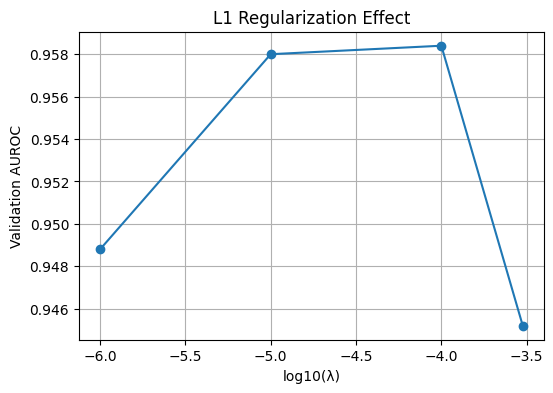

✅ Best L2 weight_decay = 1.0e-06, val_AUROC = 0.9588

L2 Regularization Test Performance:
Noise 0.10 → Acc: 0.932, AUROC: 0.986
Noise 0.20 → Acc: 0.910, AUROC: 0.966
Noise 0.30 → Acc: 0.850, AUROC: 0.926


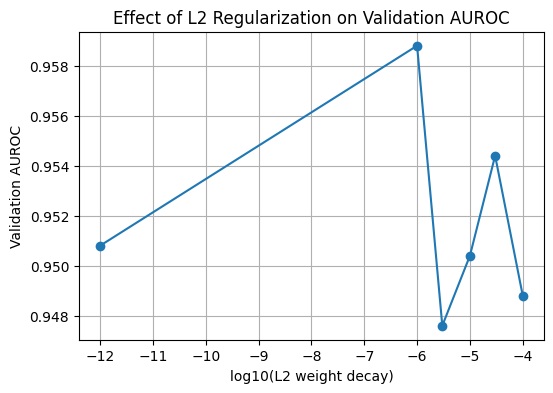

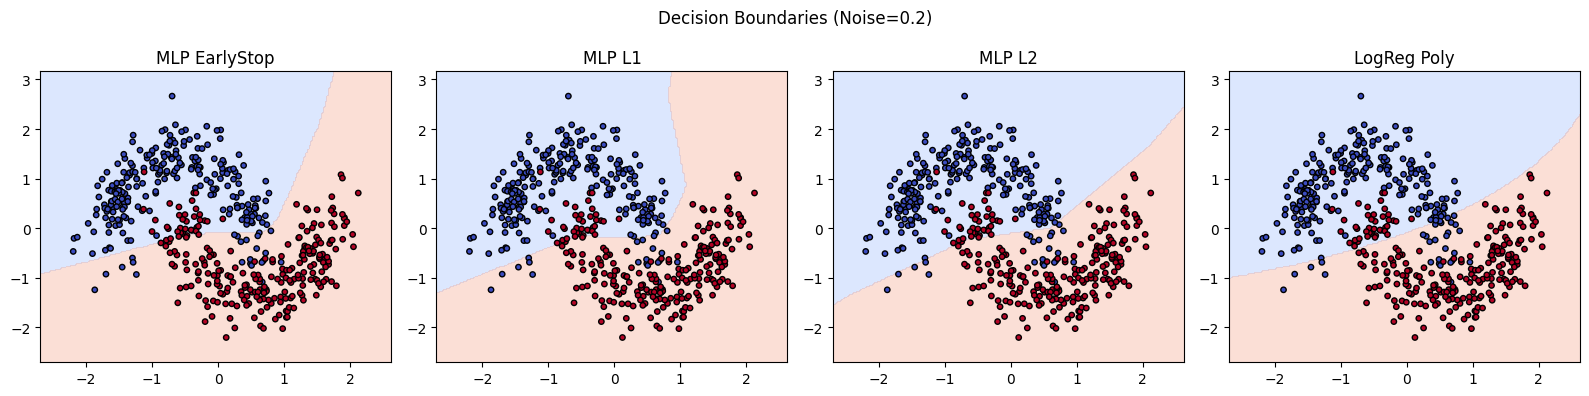

In [ ]:
np.random.seed(1337)
torch.manual_seed(1337)

def make_moons(n_samples=500, noise=0.2, seed=None):
    rng = np.random.RandomState(seed)
    n = n_samples // 2
    theta = rng.uniform(0, math.pi, n)
    x1 = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    x2 = np.stack([1 - np.cos(theta), -np.sin(theta) + 0.5], axis=1)
    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n, dtype=int), np.ones(n, dtype=int)])
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

# Train/test splits
n_points = 500
X_train_full, y_train_full = make_moons(n_points, noise=0.2, seed=1337)
X_test_20, y_test_20 = make_moons(n_points, noise=0.2, seed=1338)
X_test_10, y_test_10 = make_moons(n_points, noise=0.1, seed=1339)
X_test_30, y_test_30 = make_moons(n_points, noise=0.3, seed=1340)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=1337, stratify=y_train_full
)

# Standardization
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0, ddof=0)
def standardize(X): return (X - mean_train) / (std_train + 1e-12)

X_train_s = standardize(X_train)
X_val_s = standardize(X_val)
X_test_10_s = standardize(X_test_10)
X_test_20_s = standardize(X_test_20)
X_test_30_s = standardize(X_test_30)

# Torch helper
def to_tensor(x, y=None):
    xt = torch.tensor(x, dtype=torch.float32)
    if y is None: return xt
    return xt, torch.tensor(y, dtype=torch.float32).unsqueeze(1)

Xtr_t, ytr_t = to_tensor(X_train_s, y_train)
Xval_t, yval_t = to_tensor(X_val_s, y_val)
Xte10_t, yte10_t = to_tensor(X_test_10_s, y_test_10)
Xte20_t, yte20_t = to_tensor(X_test_20_s, y_test_20)
Xte30_t, yte30_t = to_tensor(X_test_30_s, y_test_30)

# Model Definitions
class SimpleMLP(nn.Module):
    def __init__(self, hid=8):
        super().__init__()
        self.fc1 = nn.Linear(2, hid)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hid, 1)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# -------------------------------
# Training Function
# -------------------------------
def train_model(model, Xtrain, ytrain, Xval, yval,
                n_epochs=150, lr=1e-2, weight_decay=0.0, l1_lambda=0.0, patience=15):
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()
    best_state, best_val = None, float('inf')
    epochs_no_improve = 0
    for epoch in range(n_epochs):
        model.train()
        opt.zero_grad()
        loss = loss_fn(model(Xtrain), ytrain)
        if l1_lambda > 0:
            l1 = sum(p.abs().sum() for n, p in model.named_parameters() if 'weight' in n)
            loss = loss + l1_lambda * l1
        loss.backward()
        opt.step()
        model.eval()
        with torch.no_grad():
            vloss = loss_fn(model(Xval), yval).item()
        if vloss < best_val - 1e-9:
            best_val = vloss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break
    if best_state:
        model.load_state_dict(best_state)
    return model

# Evaluation
def eval_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X).squeeze(1).cpu().numpy()
    probs = 1/(1+np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    return accuracy_score(y.cpu().numpy(), preds), roc_auc_score(y.cpu().numpy(), probs), probs

# 1. MLP with early stopping
hid = 8
mlp_es = SimpleMLP(hid)
mlp_es = train_model(mlp_es, Xtr_t, ytr_t, Xval_t, yval_t, patience=15)

acc_es_20, auc_es_20, _ = eval_model(mlp_es, Xte20_t, yte20_t)

# 2. MLP with L1 regularization
l1_grid = [1e-6, 1e-5, 1e-4, 3e-4]
l1_results = []
for lam in l1_grid:
    m = SimpleMLP(hid)
    m = train_model(m, Xtr_t, ytr_t, Xval_t, yval_t, l1_lambda=lam)
    with torch.no_grad():
        v_logits = m(Xval_t).squeeze(1).cpu().numpy()
    v_probs = 1/(1+np.exp(-v_logits))
    v_auc = roc_auc_score(y_val, v_probs)
    sparsities = {n: (np.abs(p.detach().cpu().numpy().ravel()) < 1e-3).mean()
                  for n, p in m.named_parameters() if 'weight' in n}
    l1_results.append({'lambda': lam, 'val_auc': v_auc, 'sparsity': sparsities, 'model': m})

best_l1 = max(l1_results, key=lambda x: x['val_auc'])
acc_l1_20, auc_l1_20, _ = eval_model(best_l1['model'], Xte20_t, yte20_t)

# Plot AUROC vs λ
plt.figure(figsize=(6,4))
plt.plot([np.log10(r['lambda']) for r in l1_results], [r['val_auc'] for r in l1_results], marker='o')
plt.xlabel('log10(λ)'); plt.ylabel('Validation AUROC')
plt.title('L1 Regularization Effect')
plt.grid(True); plt.show()

# ==========================================================
# 3️⃣ MLP with L2 Regularization (Ridge penalty)
# ==========================================================

l2_grid = [0.0, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4]   # you can adjust this grid
l2_results = []

for wd in l2_grid:
    m = SimpleMLP(hid)
    m = train_model(
        m,
        Xtr_t, ytr_t,
        Xval_t, yval_t,
        weight_decay=wd,    # L2 penalty coefficient
        patience=50
    )

    # Validation AUROC
    m.eval()
    with torch.no_grad():
        val_logits = m(Xval_t).squeeze(1).cpu().numpy()
        val_probs = 1 / (1 + np.exp(-val_logits))
        val_auc = roc_auc_score(y_val, val_probs)
    l2_results.append({"wd": wd, "val_auc": val_auc, "model": m})

# Pick best model by validation AUROC
best_l2 = max(l2_results, key=lambda d: d["val_auc"])
print(f"✅ Best L2 weight_decay = {best_l2['wd']:.1e}, val_AUROC = {best_l2['val_auc']:.4f}")

# Evaluate on test sets (noise = 0.10, 0.20, 0.30)
acc_l2_10, auc_l2_10, _ = eval_model(best_l2['model'], Xte10_t, yte10_t)
acc_l2_20, auc_l2_20, _ = eval_model(best_l2['model'], Xte20_t, yte20_t)
acc_l2_30, auc_l2_30, _ = eval_model(best_l2['model'], Xte30_t, yte30_t)

# Display summary
print("\nL2 Regularization Test Performance:")
print(f"Noise 0.10 → Acc: {acc_l2_10:.3f}, AUROC: {auc_l2_10:.3f}")
print(f"Noise 0.20 → Acc: {acc_l2_20:.3f}, AUROC: {auc_l2_20:.3f}")
print(f"Noise 0.30 → Acc: {acc_l2_30:.3f}, AUROC: {auc_l2_30:.3f}")

# (Optional) Plot validation AUROC vs log10(weight_decay)
plt.figure(figsize=(6,4))
plt.plot([np.log10(r['wd'] + 1e-12) for r in l2_results],
         [r['val_auc'] for r in l2_results],
         marker='o')
plt.xlabel('log10(L2 weight decay)')
plt.ylabel('Validation AUROC')
plt.title('Effect of L2 Regularization on Validation AUROC')
plt.grid(True)
plt.show()


# 3. MLP with L2 regularization
l2_grid = [0.0, 1e-5, 1e-4, 1e-3]
l2_results = []
for wd in l2_grid:
    m = SimpleMLP(hid)
    m = train_model(m, Xtr_t, ytr_t, Xval_t, yval_t, weight_decay=wd)
    with torch.no_grad():
        v_logits = m(Xval_t).squeeze(1).cpu().numpy()
    v_probs = 1/(1+np.exp(-v_logits))
    v_auc = roc_auc_score(y_val, v_probs)
    l2_results.append({'wd': wd, 'val_auc': v_auc, 'model': m})
best_l2 = max(l2_results, key=lambda x: x['val_auc'])
acc_l2_20, auc_l2_20, _ = eval_model(best_l2['model'], Xte20_t, yte20_t)

# 4. Logistic Regression (poly)
poly = PolynomialFeatures(degree=2, include_bias=False)
Xtr_poly = poly.fit_transform(X_train_s)
Xte20_poly = poly.transform(X_test_20_s)
logreg = LogisticRegression(max_iter=10000)
logreg.fit(Xtr_poly, y_train)
def eval_logreg(model, X, y):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)
    return accuracy_score(y, preds), roc_auc_score(y, probs), probs
acc_lr_20, auc_lr_20, _ = eval_logreg(logreg, Xte20_poly, y_test_20)

# Decision Boundary Visualization
def plot_decision_boundary(ax, model, model_type, X, y, poly=None):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if model_type == 'logreg':
        Z = model.predict_proba(poly.transform(grid))[:,1]
    else:
        with torch.no_grad():
            Z = torch.sigmoid(model(torch.tensor(grid, dtype=torch.float32))).numpy().ravel()
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z > 0.5, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=15, edgecolor='k')
    ax.set_title(model_type)

models = [
    ('MLP EarlyStop', mlp_es, None),
    ('MLP L1', best_l1['model'], None),
    ('MLP L2', best_l2['model'], None),
    ('LogReg Poly', logreg, poly)
]

fig, axes = plt.subplots(1, 4, figsize=(16,4))
for ax, (name, model, poly_) in zip(axes, models):
    t = 'logreg' if poly_ else 'mlp'
    plot_decision_boundary(ax, model, t, X_test_20_s, y_test_20, poly_)
    ax.set_title(name)
plt.suptitle("Decision Boundaries (Noise=0.2)")
plt.tight_layout()
plt.show()
